# Praca domowa 5
## Karol Degórski

## Klasteryzacja danych

## Import potrzebnych pakietów


In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

## Wczytanie danych clustering.csv

Zbiór danych clustering pochodzi z GitHuba i został dołączony do treści tej pracy domowej. Zawiera on dane liczbowe w wymiarze R<sup>2</sup>

In [2]:
clustering_df = pd.read_csv('clustering.csv', header=None)
clustering_df

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
...,...,...
395,22.423142,50.252807
396,-58.534367,-78.679387
397,36.446549,-11.841887
398,-101.284845,85.096034


Mamy Informacje o 400 punktach

In [3]:
clustering_df.describe()

,0,1
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


Widzimy, że wartości min i max oraz średnia odpowiednio dla kolumny 0 i 1 są do siebie zbliżone

## Wizualizacja naszych danych

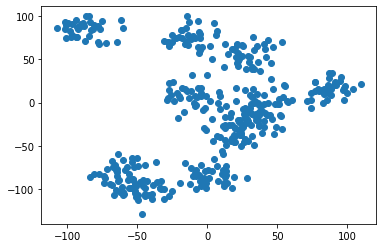

In [4]:
plt.scatter(clustering_df[0], clustering_df[1])
plt.show()

Dzięki temu wykresowi możemy nabrać intuicji, że optymalna liczba klastrów to około 6 - 8

Nie będziemy normalizowali danych, ponieważ wygląda na to że dane te opisują położenie punktów w przestrzeni i dlatego mają ściśle określone znaczenie, więc ich skalowanie mogłoby spowodować zniekształcenia

## Algorytm k-means

In [5]:
from sklearn.cluster import KMeans

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[0], X[1], c=y_kmeans, s=25, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.75)
    plt.title('K-means clusters (no. of clusters - ' + f'{n_clusters}' + ')')
    plt.show()

Sprawdźmy jak prezentuje się ten algorytm dla 6 klastrów:

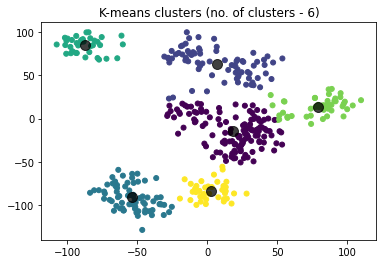

In [6]:
plot_kmeans_clusters(clustering_df, n_clusters=6)

6 klastrów wydaje się sensowne, ale niestety zielony klaster zachodzi na fioletowy. Zatem, użyjemy metody łokcia, aby sprawdzić jaką liczbę proponuje ta metoda

### Metoda łokcia

In [7]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

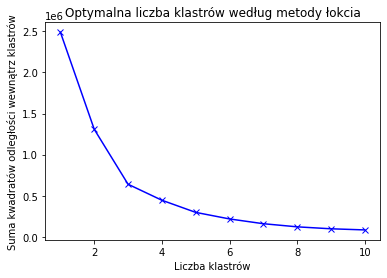

In [8]:
wcss_vec = count_wcss_scores(clustering_df, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('Liczba klastrów')
plt.ylabel('Suma kwadratów odległości wewnątrz klastrów')
plt.title('Optymalna liczba klastrów według metody łokcia')
plt.show()

Według tej metody optymalna liczba klastrów to 3 lub 4. Zobaczmy jak to wygląda:

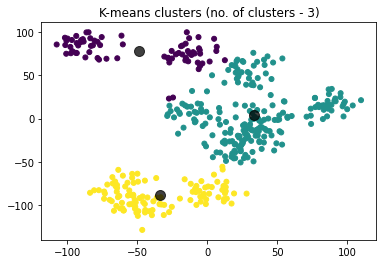

In [9]:
plot_kmeans_clusters(clustering_df, n_clusters=3)

3 nie jest wystarczającą liczbą klastrów dla naszego zadania

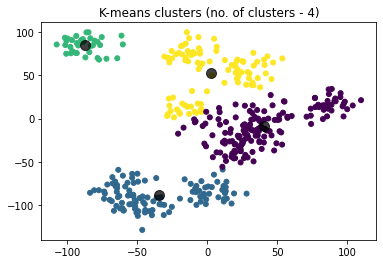

In [10]:
plot_kmeans_clusters(clustering_df, n_clusters=4)

Liczba klastrów 4 również nie wydaje się być wystarczająca. Mimo, że klastry są teraz bardziej spójne niż dla liczby klastrów 3, to dalej można zobaczyć, że co najmniej jeden dodatkowy klaster byłby przydatny

### Miara silhouette

In [11]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

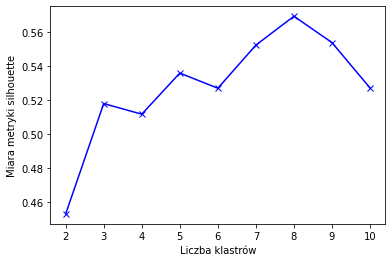

In [12]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11)
silhouette_vec = count_clustering_scores(clustering_df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('Liczba klastrów')
plt.ylabel('Miara metryki silhouette')
plt.show()

Widzimy, że ta metryka proponuje nam 8 klastrów. Zobaczmy jak to wygląda

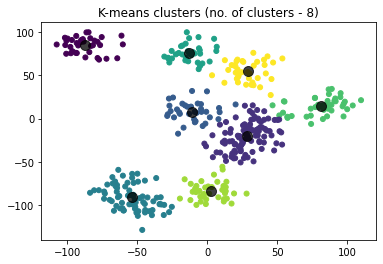

In [13]:
plot_kmeans_clusters(clustering_df, n_clusters=8)

8 klastrów wygląda bardzo dobrze. Widzimy, że użycie dwóch różnych metryk pozwala nam dojśc do całkiem dobrego rozwiązania

## Algorytm kalsteryzacji aglomeracyjnej

Wykorzystamy algorytm klasteryzacji aglomeracyjnej z linkage ward

In [14]:
from sklearn.cluster import AgglomerativeClustering


def plot_agglomerative_clusters(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward')
    y = model.fit_predict(X)
    plt.scatter(X[0], X[1], c=y, s=30, cmap='viridis')
    plt.title('Agglomerative clusters (no. of clusters - ' + f'{n_clusters}' + ')')
    plt.show()

Sprawdźmy najpierw jak wygląda ta metoda dla 8 klastrów, czyli znalezionej przez nas optymalnej liczby klastrów 

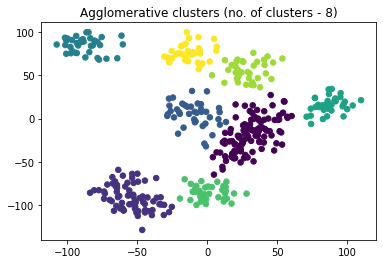

In [15]:
plot_agglomerative_clusters(clustering_df, 8)

8 klastrów wygląda dobrze - nawet lepiej niż ten uzyskany algorytmem kmeans. Jednak sprawdźmy jeszcze jak wygląda dendrogram

### Dendrogram

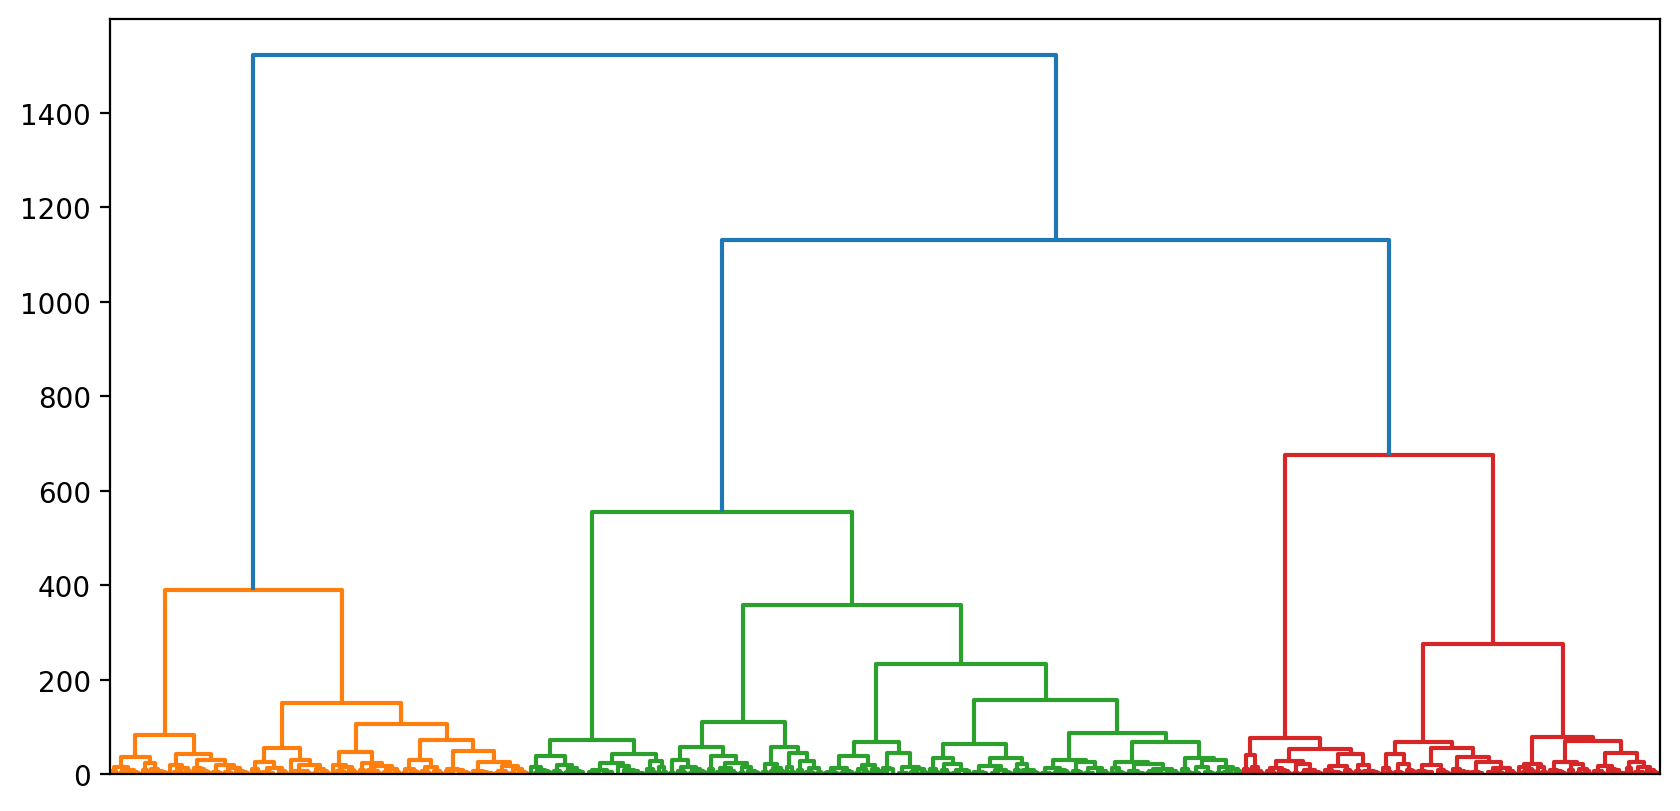

In [16]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(clustering_df, method='ward')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.show()

Z powyższego dendrogramu, mimo dużej liczby danych i małej czytelności na samym dole, możemy wywnioskować, że 7 - 9 klastrów będzie optymalną liczbą

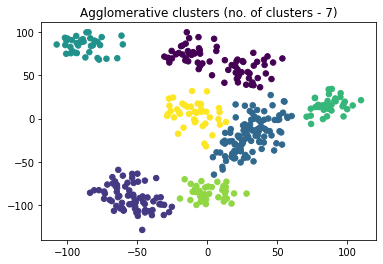

In [17]:
plot_agglomerative_clusters(clustering_df, 7)

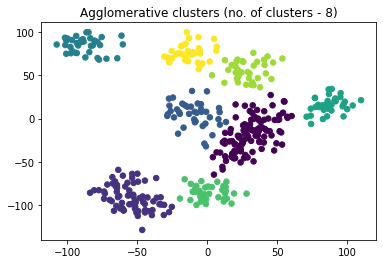

In [18]:
plot_agglomerative_clusters(clustering_df, 8)

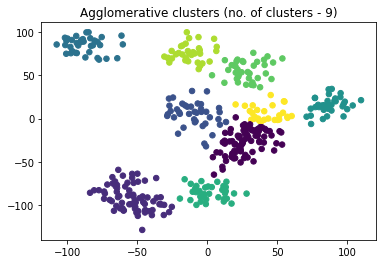

In [19]:
plot_agglomerative_clusters(clustering_df, 9)

Widzimy, że rozwiązania te są dosyć zbliżone i wszystkie z nich mają jakiś sens. Zatem tylko do naszej decyzji i naszych potrzeb zależy na jaką ostatecznie liczbę klastrów się zdecydujemy.

Jednak moim zdaniem najlepszym rozwiązaniem jest wybór ośmu klastrów. Wynika to z faktu, że dla algorytmu kmeans miara silhouette wskazała tę wartość jako optymalną oraz na podstawie dendrogramu dla algorytmu aglomeracyjnego również 8 klastrów jest liczbą odpowiednią. Jeśli chodzi o to, który algorytm poradził sobie lepiej z tym zadaniem, to będzie to algorytm aglomeracyjny z ward, ponieważ lepiej separuje dane pomiędzy różnymi klastrami

## Podsumowanie

W przestrzenii R<sup>2</sup> bardzo dobrym pomysłem jest wizualizacja naszych danych i na jej podstawie wyrobienie sobie intuicji ile klastrów powinniśmy użyć. Jednakże w przestrzeniach o większej liczbie wymiarów metryki mogą okazać się bardzo przydatne przy wyborze optymalnej liczby klastrów. Ponadto, trudno też jest jednoznacznie stwierdzić, że dana liczba klastrów jest najlepsza. Często zdarza sie, że kilka liczb jest dobrych i to do nas należy ostateczny wybór.